In [1]:
import keras
import segmentation_models as sm

Using TensorFlow backend.
Segmentation Models: using `keras` framework.


In [2]:
model = sm.Unet(backbone_name='resnet18', classes=1,encoder_weights='imagenet', encoder_freeze=True)

In [3]:
model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image
from keras import backend as K
K.set_image_data_format('channels_first')
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [22]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ElasticTransform(),
])

def preprocess_image(x, mode='caffe'):
    """ Preprocess an image by subtracting the ImageNet mean.
    Args
        x: np.array of shape (None, None, 3) or (3, None, None).
        mode: One of "caffe" or "tf".
            - caffe: will zero-center each color channel with
                respect to the ImageNet dataset, without scaling.
            - tf: will scale pixels between -1 and 1, sample-wise.
    Returns
        The input with the ImageNet mean subtracted.
    """
    # mostly identical to "https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py"
    # except for converting RGB -> BGR since we assume BGR already

    # covert always to float32 to keep compatibility with opencv
    x = x.astype(np.float32)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
    elif mode == 'caffe':
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
    return x

def preprocess_mask(x, mode='caffe'):
    return x[:,:,:1]

In [23]:
img_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, augment_seed=123, preprocess_input=preprocess_image)
img_gen = img_data_gen.flow_from_directory('./data/img', class_mode=None, shuffle=True, seed=123)
mask_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, augment_seed=123, augment_mode='mask', preprocess_input=preprocess_mask)
mask_gen = mask_data_gen.flow_from_directory('./data/msk', class_mode=None, shuffle=True, seed=123)

train_gen = zip(img_gen, mask_gen)

Found 1169 images belonging to 1 classes.
Found 1169 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


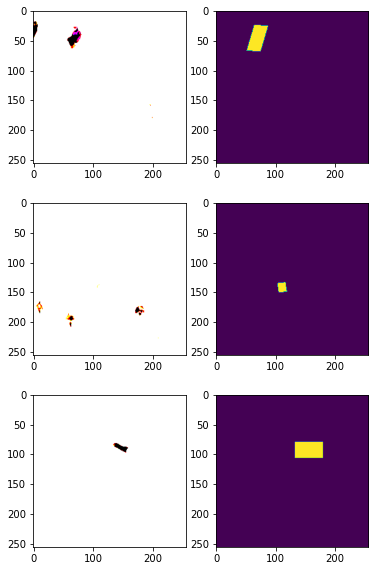

In [24]:
k = 3
image_batch, mask_batch = next(train_gen)
fix, ax = plt.subplots(k,2, figsize=(k*2,10))
for i in range(k):
    ax[i,0].imshow(image_batch[i,:,:,:])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [25]:
H = model.fit_generator(train_gen, steps_per_epoch=1000,
                        epochs=2)

Epoch 1/2


ValueError: Error when checking target: expected sigmoid to have shape (None, None, 1) but got array with shape (256, 256, 3)

In [6]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [12]:
train_generator = train_datagen.flow_from_directory('./data/img',
        target_size=(150, 150),
        batch_size=32, class_mode=None)

Found 1169 images belonging to 1 classes.


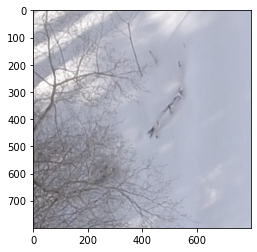

In [12]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(51, 512, 512, 3) (51, 512, 512, 1)


In [14]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 3)
print(x.shape, y.shape)

(51, 512, 512, 3) (51, 512, 512, 1)


In [16]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (40, 512, 512, 3)
y_train:  (40, 512, 512, 1)
x_val:  (11, 512, 512, 3)
y_val:  (11, 512, 512, 1)


In [17]:

from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


(2, 512, 512, 3) (2, 512, 512, 1)


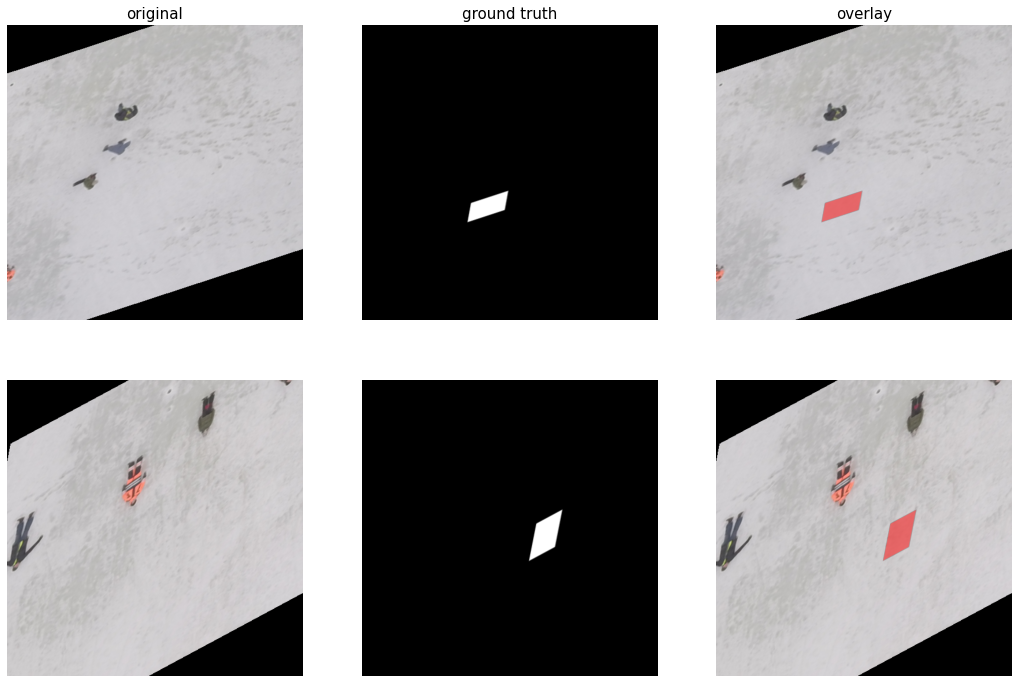

In [18]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [22]:
model.summary()

______________
stage2_unit1_relu2 (Activation) (None, None, None, 1 0           stage2_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_26 (ZeroPadding2 (None, None, None, 1 0           stage2_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit1_conv2 (Conv2D)     (None, None, None, 1 147456      zero_padding2d_26[0][0]          
__________________________________________________________________________________________________
stage2_unit1_sc (Conv2D)        (None, None, None, 1 8192        stage2_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_11 (Add)                    (None, None, None, 1 0           stage2_unit1_conv2[0][0]         
                                                                 stage2_unit1_sc[0][0]        

In [23]:
model.fit(x_train, y_train, epochs=2)

Epoch 1/2


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv0_1/convolution (defined at /home/gosha20777/anaconda3/lib/python3.8/site-packages/keras/backend/tensorflow_backend.py:3007) ]] [Op:__inference_keras_scratch_graph_24554]

Function call stack:
keras_scratch_graph
